In [27]:
import glob
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Load car and not car data
cars = []
not_cars = []

# Get car paths
car_paths = ["./udacity-dataset/vehicles/GTI_Far"
"./udacity-dataset/vehicles/GTI_Left",
"./udacity-dataset/vehicles/GTI_MiddleClose",
"./udacity-dataset/vehicles/GTI_Right",
"./udacity-dataset/vehicles/KITTI_extracted",
"./datasets/Dense",
"./datasets/Sunny", 
"./datasets/Urban"]

for i in xrange(0, len(car_paths)):
    car_path = car_paths[i]
    for file in glob.glob(os.path.join(car_path, "*.png")):
        cars.append(file)
    # extra dataset
    if car_path.find("./datasets/") != -1:
        for file in glob.glob(os.path.join(car_path, "*.jpeg")):
            cars.append(file)

# Get not car paths
not_car_paths = ["./udacity-dataset/non-vehicles/Extras",
"./udacity-dataset/non-vehicles/GTI"]

for i in xrange(0, len(not_car_paths)):
    not_car_path = not_car_paths[i]
    for file in glob.glob(os.path.join(not_car_path, "*.png")):
        not_cars.append(file)

print "Loaded all files..."
        
# Extract HOG for features
def extract_hog_features(img, channel=0, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False, visualise=False, feature_vector=True):
    if channel == "ALL":
        for j in xrange(0, img.shape[2]):
            hog_features = hog(img[:,:,j], orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=transform_sqrt, visualise=visualise, feature_vector=feature_vector)
            hog_features = np.ravel(hog_features)
            print hog_features
    else:
        hog_features = hog(img[:,:,channel], orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=transform_sqrt, visualise=visualise, feature_vector=feature_vector)

    return hog_features

def extract_bin_spacial_features(image, size=(32, 32)):
    return cv2.resize(image, size).ravel()


def extract_color_hist_features(image, nbins=32, bins_range=(0,256)):

    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features




def extract_training_features(files, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    features = []

    for file in files:
        file_features = []
        image = cv2.imread(file)
        if spatial_feat:
            file_features.append(extract_bin_spacial_features(image))
        if hist_features:
            file_features.append(extract_color_hist_features(image))
        if hog_features:
            file_features.append(extract_hog_features(image))

        features.append(np.concatenate(file_features))
        
    return features


def extract_features(image, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    
    file_features = []
    
    if spatial_feat:
        file_features.append(extract_bin_spacial_features(image))
    if hist_features:
        file_features.append(extract_color_hist_features(image))
    if hog_features:
        file_features.append(extract_hog_features(image))
        
    return np.concatenate(file_features)


def normalize_features(raw_features):
    normalized_features = []
    return normalized_features



Loaded all files...


In [28]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell #16
cell_per_block = 1 # HOG cells per block #2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

print "extracting features..."

car_features = extract_training_features(cars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)

not_car_features = extract_training_features(not_cars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)

print "done extracting features"

# normalize feature vectors

print "normalize features"

X = np.vstack((car_features, not_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

print scaled_X.shape

extracting features...
done extracting features
normalize features
(22677, 1764)


In [20]:
# TRAIN WITH DENSE DATASET



[[ 1  2  3]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]


In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from sklearn.cross_validation import train_test_split
import numpy as np

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

num_features = scaled_X.shape[1]

# Build model
keras_model = Sequential()
keras_model.add(Dense(num_features, input_shape=(num_features,), kernel_initializer='uniform', activation='sigmoid'))
keras_model.add(Dense(2, kernel_initializer='uniform', activation='sigmoid'))
keras_model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Compile model
keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
keras_model.fit(X_train, y_train, epochs=2, batch_size=10)
print "finished fitting model"

# Evaluate the model
scores = keras_model.evaluate(scaled_X, y)
print("%s: %.2f%%" % (keras_model.metrics_names[1], scores[1]*100))

print "finished evaluating model"

Epoch 1/2
18141/18141 [==============================] - 87s - loss: 0.4236 - acc: 0.9544       

In [40]:
keras_model.save('car_model.h5')
print "model saved to disk"

model saved to disk


In [6]:
import tensorflow as tf
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Configured Using:',orient,'orientations',
       pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print ('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print ("{} seconds to train classifier...".format(round(t2-t1, 5)))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


('Configured Using:', 9, 'orientations', 16, 'pixels per cell and', 1, 'cells per block')
('Feature vector length:', 1764)
6.14 seconds to train classifier...
('Test Accuracy of SVC = ', 0.9491)


In [41]:
def sliding_windows(img, x_range, y_range, window_size, xy_overlap_percent):
    windows = []
    
    x_start = x_range[0];
    x_end = x_range[1];
    y_start = y_range[0];
    y_end = y_range[1];
    
    # check values and use full image size if parameter is not given
    if (x_start == None):
        x_start = 0;
    if (x_end == None):
        x_end = img.shape[1];
    if (y_start == None):
        y_start = 0;
    if (y_end == None):
        y_end = img.shape[0];

    # window span
    x_span = x_end - x_start;
    y_span = y_end - y_start;

    # how much to move the window by each step
    x_step_size = window_size[0] * (1 - xy_overlap_percent[0])
    y_step_size = window_size[1] * (1 - xy_overlap_percent[1])

    # the region that overlaps
    x_overlap_region = window_size[0] * xy_overlap_percent[0]
    y_overlap_region = window_size[1] * xy_overlap_percent[1]

    # num of times the window fits in the span
    x_num_steps = np.int((x_span - x_overlap_region) / x_step_size)
    y_num_steps = np.int((y_span - y_overlap_region) / y_step_size)

    for y in range(y_num_steps):
        for x in range(x_num_steps):
            window_start = (np.int(x * x_step_size + x_start), np.int(y * y_step_size + y_start))
            window_end = (np.int(window_start[0] + window_size[0]), np.int(window_start[1] + window_size[1]))
            windows.append((window_start, window_end))
        
    return windows

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import seaborn as sns

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def get_classified_windows(image):
    # Returns windows that classifier claims to be a car

    xy_window = [(64,64), (96,96), (128,128), (256,256)]
#     xy_window = [(32,32), (64,64), (128,128), (256,256)]
    y_start_stop = [[300, 450], [300, 450], [300, None], [300, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = sliding_windows(image, [None, None], y_start_stop[i], 
                            xy_window[i], (0.75, 0.75))
        windows = search_windows(image, windows, keras_model, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                        spatial_feat, hist_feat, hog_feat)
        windows_temp.append(windows)

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    return windows_final


# image = cv2.imread("test.jpeg")
# heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

# classified_windows = get_classified_windows(image)
# heatmap = apply_heat(heatmap, classified_windows)
# labels = label(heatmap)
# final_image = draw_cars(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), labels)
# window_img = draw_boxes(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), classified_windows, color=(0, 0, 255), thick=6)
# heatmap_image = np.clip(heatmap, 0, 255)

# with sns.axes_style("white"):
#     print "plotting image..."
#     fig = plt.figure(figsize=(20, 20))
#     plt.subplot(121)
#     plt.imshow(window_img)
#     plt.subplot(122)
#     plt.imshow(heatmap_image, cmap='hot')
#     plt.subplot(122)
#     plt.imshow(final_image)

In [46]:
def search_windows(img, windows, clf, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    on_windows = []
    for window in windows:
        startx = window[0][0]
        starty = window[0][1]
        endx = window[1][0]
        endy = window[1][1]

        cropped = img[starty:endy, startx:endx]

        test_img = cv2.resize(cropped, (64, 64))
        features = extract_features(test_img, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_features=hist_features, hog_features=hog_features)

        # transform features to be fed into classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        #print prediction
        if prediction > 0.5:
            on_windows.append(window)

    return on_windows

In [44]:
from scipy.ndimage.measurements import label

# Heat values must be over threshold to be valid
HEAT_THRESHOLD = 2


def apply_heat(heatmap, windows):
    
    for window in windows:
        startx, starty = window[0][0], window[0][1]
        endx, endy = window[1][0], window[1][1]
        # Add heat value of 1 to all pixels inside classified 'true' window
        heatmap[starty:endy, startx:endx] += 1
    
    # Use threshold to zero out values
    heatmap[heatmap <= HEAT_THRESHOLD] = 0
    return heatmap


def draw_cars(img, labels):
    # Labels contains ([Image Array], number of heat blobs)
    for car_number in range(1, labels[1]+1):
        # Get pixels for the corresponding labeled heat
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Get the boundary of the heat
        outline = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, outline[0], outline[1], (0,0,255), 6)

    return img


In [11]:
from moviepy.editor import VideoFileClip


def process_frame(image):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    classified_windows = get_classified_windows(image)
    heatmap = apply_heat(heatmap, classified_windows)
    labels = label(heatmap)
    final_image = draw_cars(image, labels)
    return final_image


video = "Sunny/april21.avi"
video = VideoFileClip(video)


detection_video = video.fl_image(process_frame)
%time detection_video.write_videofile("vehicle_detection.mp4", audio=False)


[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


100%|█████████▉| 300/301 [03:59<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

CPU times: user 4min 10s, sys: 19.2 s, total: 4min 29s
Wall time: 3min 59s


[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11089878]]
[[ 0.93246585]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11110019]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078308]]
[[ 0.11166996]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.86892623]]
[[ 0.110792]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.1107825]]
[[ 0.11078236]]
[[ 0.11343106]]
[[ 0.11078236]]
[[ 0.11078243]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.93246585]]
[[ 0.11078338]]
[[ 0.11078236]]
[[ 0.11078236]]
[[ 0.110841

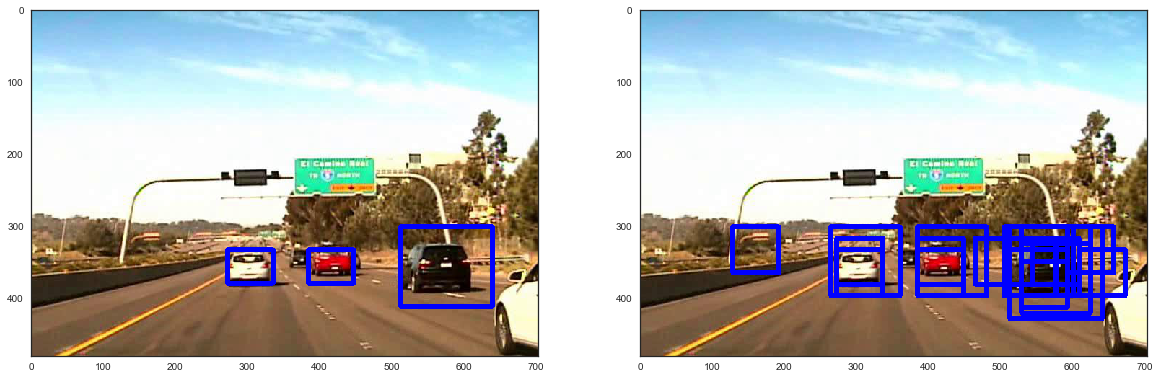

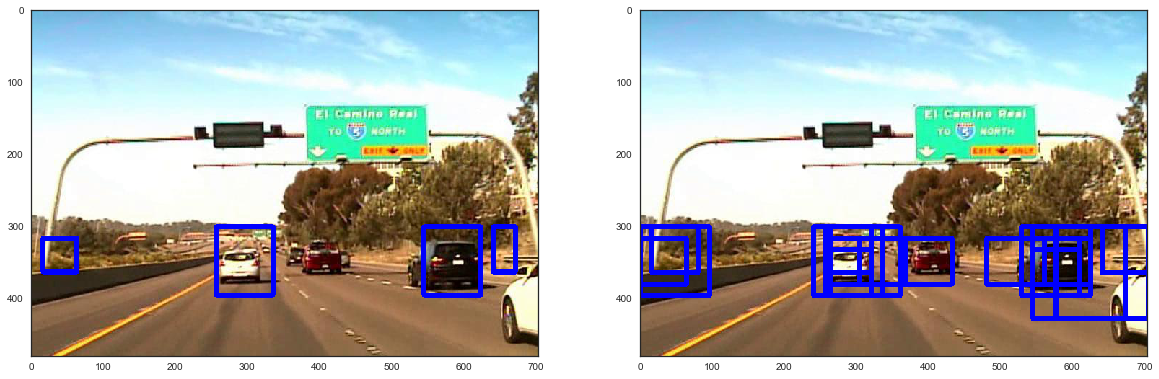

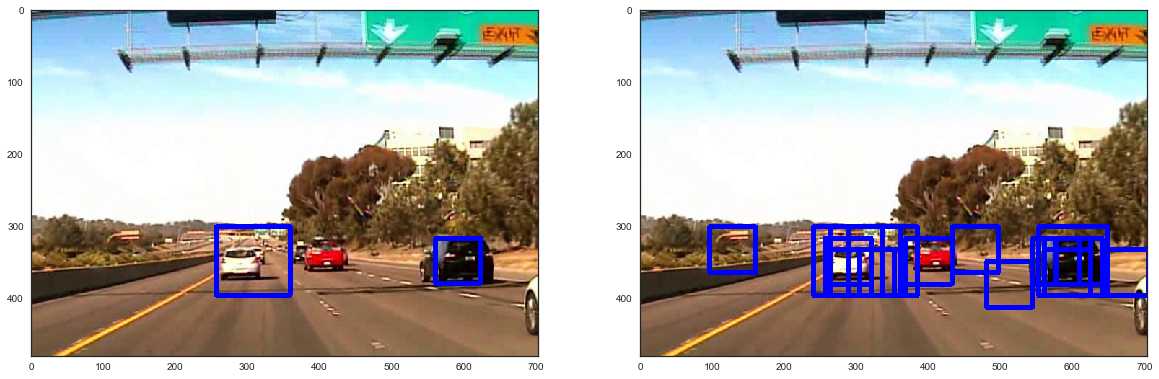

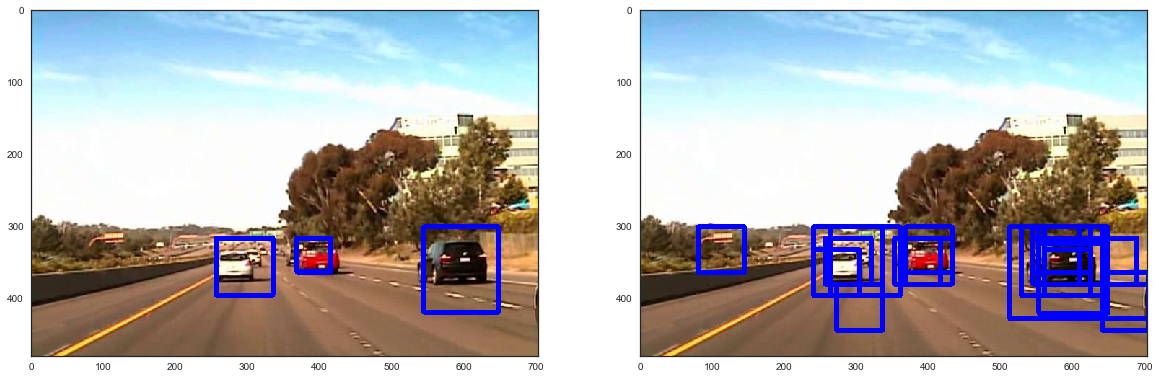

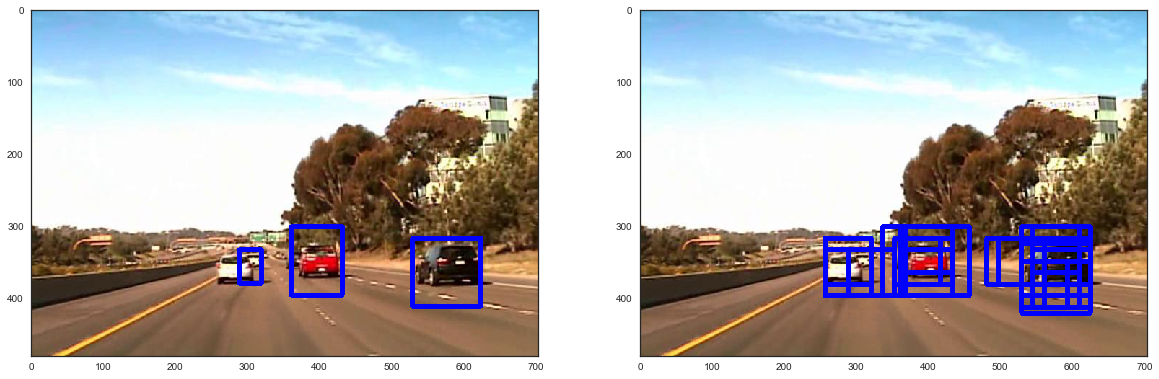

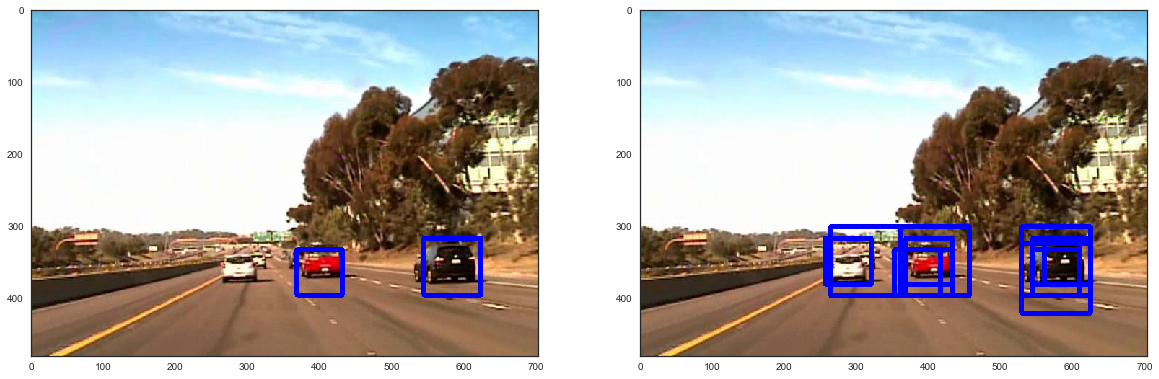

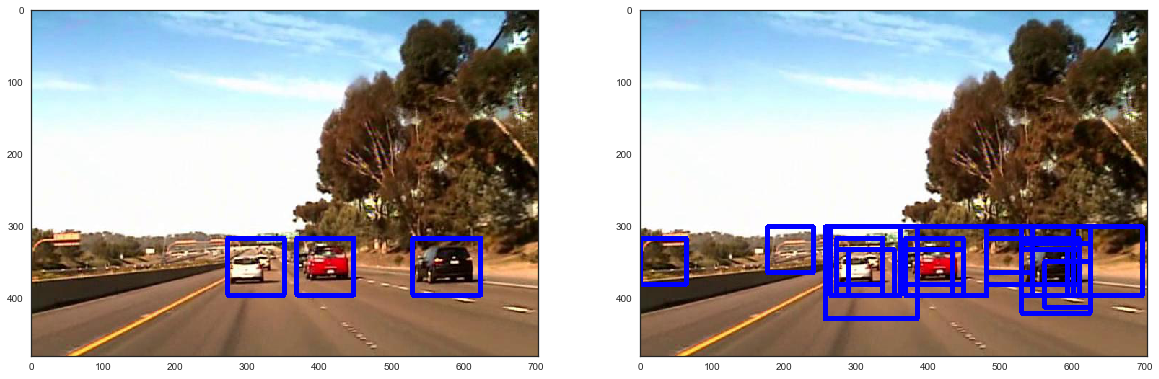

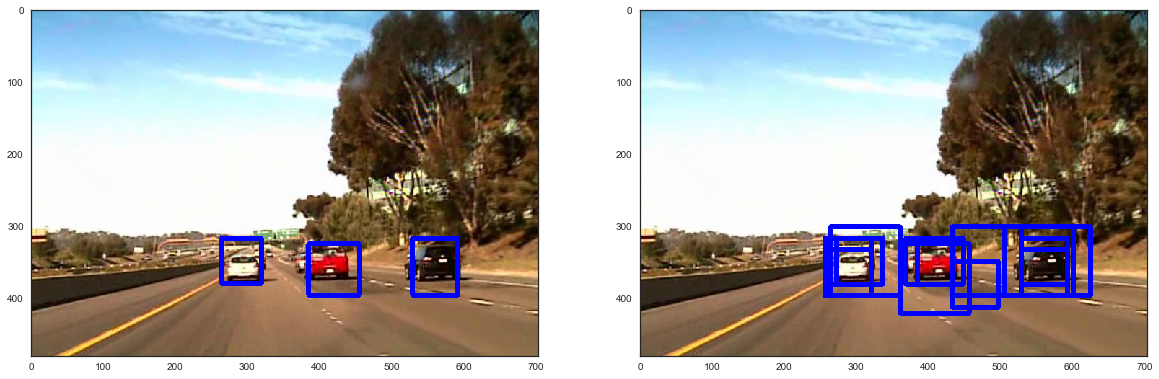

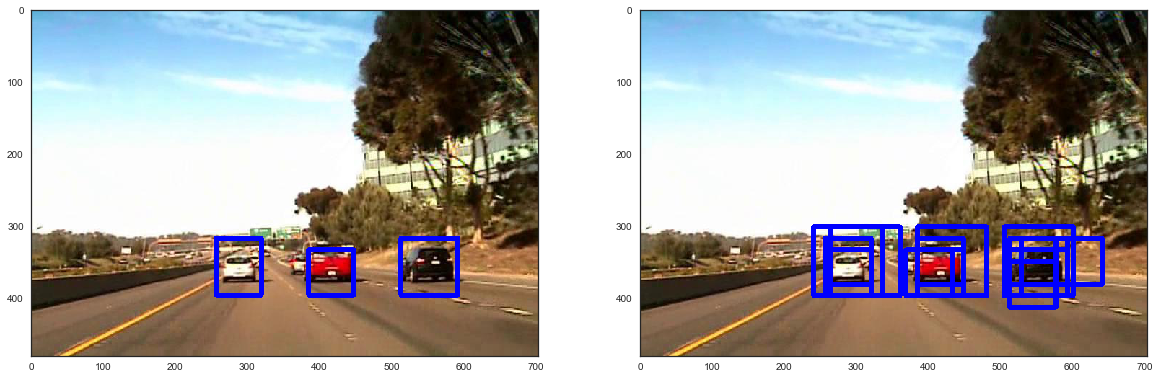

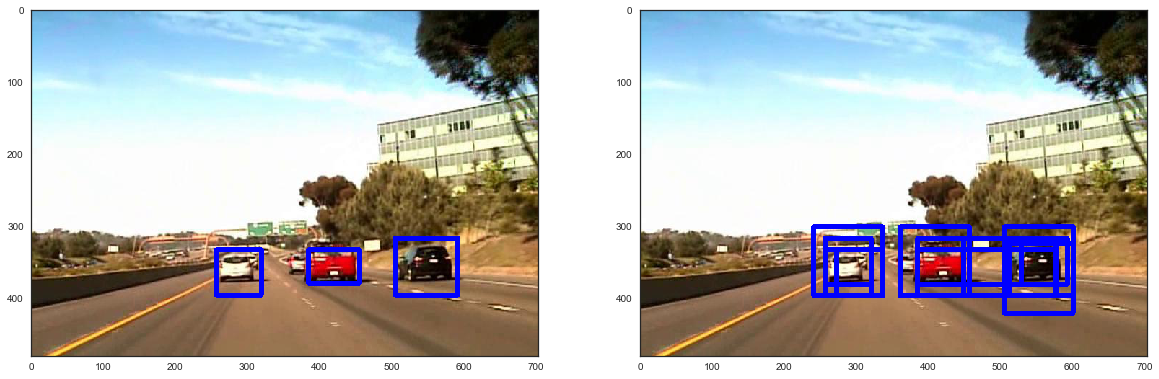

In [47]:
from moviepy.editor import VideoFileClip

video = "datasets/Sunny/april21.avi"
# video = "datasets/Urban/march9.avi"
video = VideoFileClip(video)

frames = []
for i in range(10):
    frame_name = "frame{}.jpeg".format(i)
    video.save_frame(frame_name, t=i)
    frames.append(frame_name)


final_images = []
window_images = []
for frame in frames:
    img = cv2.imread(frame)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    classified_windows = get_classified_windows(img)
    heatmap = apply_heat(heatmap, classified_windows)
    labels = label(heatmap)
    final_image = draw_cars(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)
    window_img = draw_boxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), classified_windows, color=(0, 0, 255), thick=6)
    
    final_images.append(final_image)
    window_images.append(window_img)


with sns.axes_style("white"):
    print "plotting image..."

    for i in xrange(len(frames)):
        fig = plt.figure(i, figsize=(20,20))
        plt.title('Frame: {}'.format(frames[i]))
        plt.subplot(121)
        plt.imshow(final_images[i])
        plt.subplot(122)
        plt.imshow(window_images[i])

